In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

import env
import wrangle as w
import split_scale as ss


df = w.wrangle_telco()

train, test  = ss.split_my_data(df, train_pct = .8, random_seed = 123)

X_train = train.drop(columns = 'total_charges')

X_test = test.drop(columns = "total_charges")

y_train = train[["total_charges"]]

y_test = test[["total_charges"]]


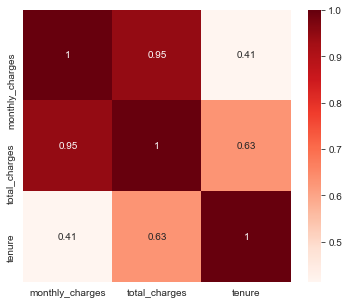

In [14]:
# Using Pearson Correlation

sns.set_style('whitegrid')
plt.figure(figsize=(6,5))
cor = train.corr()
sns.heatmap(cor, annot = True, cmap=plt.cm.Reds)

# To view just the correlations of each attribute with the target variable, and filter down to only those above a certain value:
# Correlation with output variable
cor_target = abs(cor["total_charges"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]

In [2]:
# Write a function, select_kbest_not_scaled() that takes X_train, y_train and k as input
# (X_train and y_train should not be scaled!) and returns a list of the top k features.

In [9]:
from sklearn.feature_selection import SelectKBest, f_regression

def select_kbest_freg_unscaled(X_train, y_train, k):
    freg_selector = SelectKBest(f_regression, k)
    freg_selector.fit(X, y)
    freg_support = freg_selector.get_support()
    freg_feature = X.loc[:,freg_support].columns.tolist()
    return freg_feature

In [ ]:
# Write a function, select_kbest_freg() that takes X_train, y_train (scaled) and k as input 
# and returns a list of the top k features.

In [ ]:
def select_kbest_freg_scaled(X_train, y_train, k):
    X_scaler, X_train_scaled_data, X_test_scaled_data = split_scale.standard_scaler(X_train)
    y_scaler, y_train_scaled_data, y_test_scaled_data = split_scale.standard_scaler(y_train)

    f_selector = SelectKBest(f_regression,k=k)
    f_selector.fit(X_train_scaled_data, y_train_scaled_data)

    f_support = f_selector.get_support()
    f_feature = X_train_scaled_data.loc[:,f_support].columns.tolist()
    return f_feature


In [ ]:
# Write a function, ols_backward_elimination() that takes X_train and y_train (scaled) as input 
# and returns selected features based on the ols backwards elimination method.

In [12]:
import statsmodels.api as sm
def ols_backward_elimination(X_train, y_train):
    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    cols = list(X_train.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X_train[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y_train,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break

    selected_features_BE = cols
    return selected_features_BE

In [ ]:
# Write a function, lasso_cv_coef() that takes X_train and y_train as input and returns the coefficients 
# for each feature, along with a plot of the features and their weights.

In [ ]:
from sklearn.linear_model import LassoCV
import matplotlib

def lasso_cv_coef(X_train, y_train):
    reg = LassoCV()
    reg.fit(X_train,y_train)
    coef = pd.Series(reg.coef_, index = X_train.columns)
    imp_coef = coef.sort_values()
    matplotlib.rcParams['figure.figsize'] = (4.0, 5.0)
    imp_coef.plot(kind ='barh')
    plt.title("Feature importance using Lasso Model")
    return imp_coef


In [ ]:
# Write 3 functions, the first computes the number of optimum features (n) using rfe,
# the second takes n as input and returns the top n features, 
# and the third takes the list of the top n features as input 
# and returns a new X_train and X_test dataframe with those top features , recursive_feature_elimination() 
# that computes the optimum number of features (n) and returns the top n features.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE



In [ ]:
# Write 3 functions, the first computes the number of optimum features (n) using rfe

def num_optimal_features(X_train, y_train, X_test, y_test):
    '''discover the optimal number of features, n, using our scaled x and y dataframes, recursive feature
    elimination and linear regression (to test the performance with each number of features).
    We will use the output of this function (the number of features) as input to the next function
    optimal_features, which will then run recursive feature elimination to find the n best features
    '''
    features_range = range(1, len(X.columns)+1)
    # len(features_range)

    # set "high score" to be the lowest possible score
    high_score = 0

    # variables to store the feature list and number of features
    number_of_features = 0
    # score_list = []

    # write the problem without a loop, but instead with all features available,
    # so feature count = len(X_train_scaled.columns)
    for n in features_range:
        model = LinearRegression()
        train_rfe = RFE(model, n).fit_transform(X, y)
        model.fit(train_rfe, y)
        score = model.score(train_rfe, y)
        # score_list.append(score)
        if(score > high_score):
            high_score = score
            number_of_features = n

    return number_of_features, score


In [ ]:
# the second takes n as input and returns the top n features, 


def optimal_features(n):
    '''Taking the output of optimal_number_of_features, as n, and use that value to 
    run recursive feature elimination to find the n best features'''
    cols = list(X_train.columns)
    model = LinearRegression()
    
    #Initializing RFE model
    rfe = RFE(model, number_of_features)

    #Transforming data using RFE
    train_rfe = rfe.fit_transform(X_train,y_train)
    test_rfe = rfe.transform(X_test)
    
    #Fitting the data to model
    model.fit(train_rfe, y_train)
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    
    X_train_rfe = pd.DataFrame(train_rfe, columns=selected_features_rfe)
    X_test_rfe = pd.DataFrame(test_rfe, columns=selected_features_rfe)
    
    return selected_features_rfe, X_train_rfe, X_test_rfe

In [5]:
# and the third takes the list of the top n features as input
# and returns a new X_train and X_test dataframe with those top features

def n_to_X_train_and_test(features):
    new_X_train = X_train_scaled[features]
    new_X_test = X_test_scaled[features]
    return new_X_train, new_X_test

In [6]:
# Recursive_feature_elimination() that computes the optimum number of features (n) and returns the top n features.

def recursive_feature_elimination(X_train, y_train, X_test, y_test):
    return optimal_features(num_optimal_features(X_train, y_train, X_test, y_test))